In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
# Set the seed for reproducibility
torch.manual_seed(42)


/home/himalaya/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:
# MNIST dataset mean and standard deviation
mnist_mean = 0.1307
mnist_std = 0.3081


# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((mnist_mean,), (mnist_std,))
])

# Paths to the MNIST training and testing datasets
training_data_path = 'Downloads/mnist/training'
testing_data_path = 'Downloads/mnist/testing'

# Load the MNIST training dataset
train_dataset = datasets.ImageFolder(root=training_data_path, transform=transform)

# Load the MNIST test dataset
test_dataset = datasets.ImageFolder(root=testing_data_path, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Check the size of the datasets
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of batches in the training loader: {len(train_loader)}")
print(f"Number of test examples: {len(test_dataset)}")
print(f"Number of batches in the test loader: {len(test_loader)}")

Number of training examples: 100
Number of batches in the training loader: 4
Number of test examples: 10000
Number of batches in the test loader: 313


To simulate a few shot situation we begin with only 10 images from MNIST datastet for eahc class

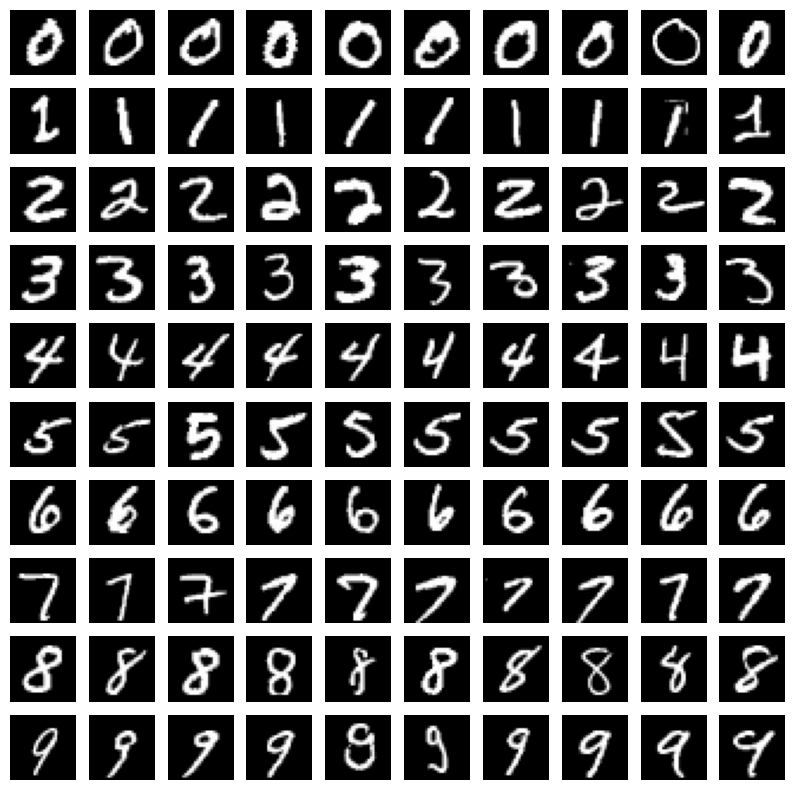

In [ ]:
# Dictionary to store images for each class
class_images = {i: [] for i in range(10)}

# Traverse through the folder and collect images
for class_label in range(10):
    class_path = os.path.join(training_data_path, str(class_label))

    # Iterate through images in the class folder
    for image_file in os.listdir(class_path)[:10]:
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        class_images[class_label].append(image)

# Plot 10x10 grid
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i in range(10):
    for j in range(10):
        axs[i, j].imshow(class_images[i][j], cmap="gray")
        axs[i, j].axis("off")

plt.show()

In [ ]:
# Load pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Modify the output layer to match the number of classes in the MNIST dataset
num_classes = 10
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)


In [ ]:
# Evaluate the model on the test set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
resnet18.eval()


correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_percentage = (correct / total) * 100
print(f"Pre-trained ResNet-18 Test Accuracy: {accuracy_percentage:.2f}%")

Pre-trained ResNet-18 Test Accuracy: 10.40%


In [ ]:
# Fine-tune the model for 25 epochs on 10 samples per class
num_epochs = 25

for epoch in range(num_epochs):
    resnet18.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} complete")

print("Fine-tuning complete!")


Epoch 1/25 complete
Epoch 2/25 complete
Epoch 3/25 complete
Epoch 4/25 complete
Epoch 5/25 complete
Epoch 6/25 complete
Epoch 7/25 complete
Epoch 8/25 complete
Epoch 9/25 complete
Epoch 10/25 complete
Epoch 11/25 complete
Epoch 12/25 complete
Epoch 13/25 complete
Epoch 14/25 complete
Epoch 15/25 complete
Epoch 16/25 complete
Epoch 17/25 complete
Epoch 18/25 complete
Epoch 19/25 complete
Epoch 20/25 complete
Epoch 21/25 complete
Epoch 22/25 complete
Epoch 23/25 complete
Epoch 24/25 complete
Epoch 25/25 complete
Fine-tuning complete!


In [ ]:
resnet18.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_percentage = (correct / total) * 100
print(f"Fine-tuned ResNet-18 Test Accuracy: {accuracy_percentage:.2f}%")

Fine-tuned ResNet-18 Test Accuracy: 92.16%


In [ ]:
# Define data augmentation transformations
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-10, 10)),  # Random rotation between -10 and 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=3)  # Apply Gaussian blur with a kernel size of 3
])

In [ ]:
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),  # Convert to grayscale with 10% probability
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-10, 10)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
])

In [ ]:
augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),  # Convert to grayscale with 10% probability
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=(-10, 10)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomApply([transforms.CenterCrop(size=(150, 150))], p=0.5)  # Random center crop with 50% probability
])

In [ ]:
import os
from tqdm import tqdm

# Define the path to the original training dataset
original_data_path = "Downloads/mnist/training"
augmented_data_path = "Downloads/mnist/augmented_training_2"

# Create the augmented data folder if it doesn't exist
os.makedirs(augmented_data_path, exist_ok=True)

# Iterate over the classes
for class_label in tqdm(range(10), desc="Augmenting Classes"):
    class_folder = os.path.join(original_data_path, str(class_label))

    # Create a new folder for the augmented images of this class
    augmented_class_folder = os.path.join(augmented_data_path, str(class_label))
    os.makedirs(augmented_class_folder, exist_ok=True)

    # Iterate over the original images in this class
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)

        # Load the original image
        original_image = Image.open(image_path)

        # Apply augmentations to create 100 new images
        augmented_images = [augmentation_transform(original_image) for _ in range(100)]

        # Save the augmented images to the new folder
        for i, augmented_image in enumerate(augmented_images):
            augmented_image_name = f"{image_name.split('.')[0]}_aug_{i}.jpg"
            augmented_image_path = os.path.join(augmented_class_folder, augmented_image_name)
            augmented_image.save(augmented_image_path)

print("Augmentation complete!")


Augmenting Classes: 100%|███████████████████████| 10/10 [00:18<00:00,  1.88s/it]

Augmentation complete!


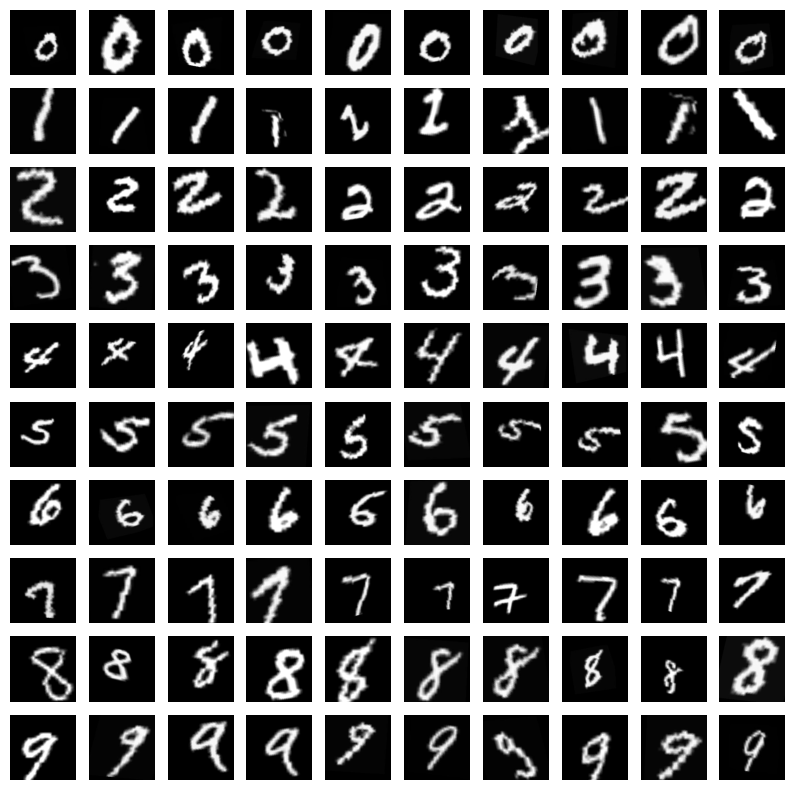

In [ ]:
augmented_data_path = "Downloads/mnist/augmented_training_1"
# Dictionary to store images for each class
class_images = {i: [] for i in range(10)}

# Traverse through the folder and collect images
for class_label in range(10):
    class_path = os.path.join(augmented_data_path, str(class_label))

    # Iterate through images in the class folder
    for image_file in os.listdir(class_path)[:10]:
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        class_images[class_label].append(image)

# Plot 10x10 grid
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i in range(10):
    for j in range(10):
        axs[i, j].imshow(class_images[i][j], cmap="gray")
        axs[i, j].axis("off")

plt.show()

Below are the reslkts after applying augmentations on the MNIST datastt


In [ ]:
aug_training_data_path = 'Downloads/mnist/augmented_training_1'
# Load the MNIST training dataset
aug_train_dataset = datasets.ImageFolder(root=aug_training_data_path, transform=transform)

# Create data loaders
batch_size = 256
aug_train_loader = DataLoader(dataset=aug_train_dataset, batch_size=batch_size, shuffle=True)

# Check the size of the datasets
print(f"Number of training examples: {len(aug_train_dataset)}")
print(f"Number of batches in the training loader: {len(aug_train_loader)}")

Number of training examples: 10000
Number of batches in the training loader: 40


In [ ]:
# Fine-tune the model for 25 epochs
num_epochs = 25

for epoch in range(num_epochs):
    resnet18.train()
    for inputs, labels in aug_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} complete")

print("Fine-tuning with Augmentation complete!")


Epoch 1/25 complete
Epoch 2/25 complete
Epoch 3/25 complete
Epoch 4/25 complete
Epoch 5/25 complete
Epoch 6/25 complete
Epoch 7/25 complete
Epoch 8/25 complete
Epoch 9/25 complete
Epoch 10/25 complete
Epoch 11/25 complete
Epoch 12/25 complete
Epoch 13/25 complete
Epoch 14/25 complete
Epoch 15/25 complete
Epoch 16/25 complete
Epoch 17/25 complete
Epoch 18/25 complete
Epoch 19/25 complete
Epoch 20/25 complete
Epoch 21/25 complete
Epoch 22/25 complete
Epoch 23/25 complete
Epoch 24/25 complete
Epoch 25/25 complete
Fine-tuning with Augmentation complete!


In [ ]:
resnet18.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_percentage = (correct / total) * 100
print(f"Fine-tuned with Augmentaion ResNet-18 Test Accuracy: {accuracy_percentage:.2f}%")

Fine-tuned with Augmentaion ResNet-18 Test Accuracy: 95.21%


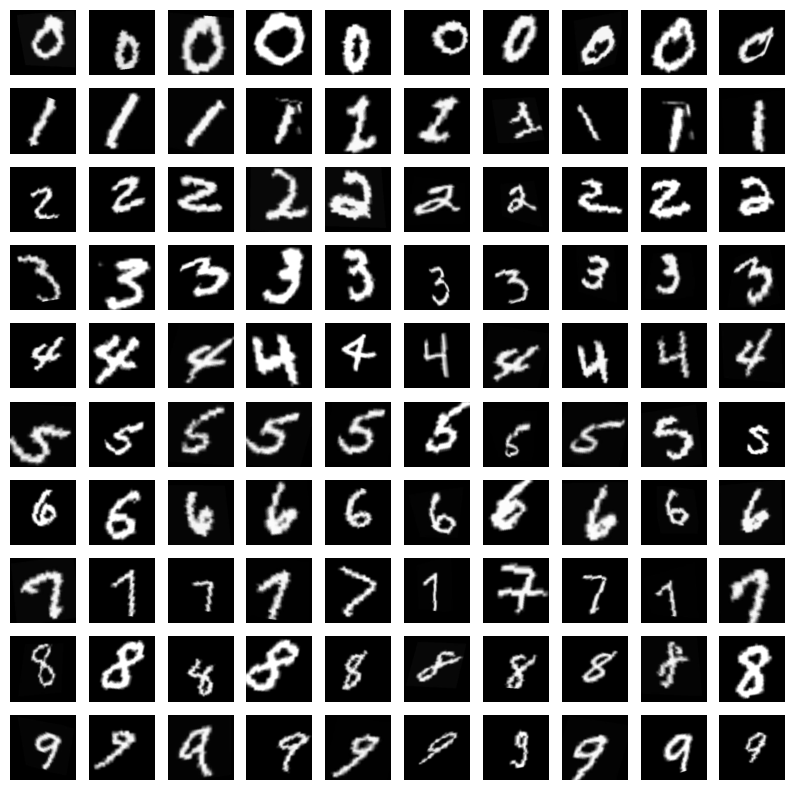

In [ ]:
augmented_data_path = "Downloads/mnist/augmented_training_2"
# Dictionary to store images for each class
class_images = {i: [] for i in range(10)}

# Traverse through the folder and collect images
for class_label in range(10):
    class_path = os.path.join(augmented_data_path, str(class_label))

    # Iterate through images in the class folder
    for image_file in os.listdir(class_path)[:10]:
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        class_images[class_label].append(image)

# Plot 10x10 grid
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i in range(10):
    for j in range(10):
        axs[i, j].imshow(class_images[i][j], cmap="gray")
        axs[i, j].axis("off")

plt.show()

In [ ]:
# Fine-tune the model for 25 epochs
num_epochs = 25

for epoch in range(num_epochs):
    resnet18.train()
    for inputs, labels in aug_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} complete")

print("Fine-tuning with Augmentation complete!")


Epoch 1/25 complete
Epoch 2/25 complete
Epoch 3/25 complete
Epoch 4/25 complete
Epoch 5/25 complete
Epoch 6/25 complete
Epoch 7/25 complete
Epoch 8/25 complete
Epoch 9/25 complete
Epoch 10/25 complete
Epoch 11/25 complete
Epoch 12/25 complete
Epoch 13/25 complete
Epoch 14/25 complete
Epoch 15/25 complete
Epoch 16/25 complete
Epoch 17/25 complete
Epoch 18/25 complete
Epoch 19/25 complete
Epoch 20/25 complete
Epoch 21/25 complete
Epoch 22/25 complete
Epoch 23/25 complete
Epoch 24/25 complete
Epoch 25/25 complete
Fine-tuning with Augmentation complete!


In [ ]:
resnet18.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_percentage = (correct / total) * 100
print(f"Fine-tuned with Augmentaion ResNet-18 Test Accuracy: {accuracy_percentage:.2f}%")

Fine-tuned with Augmentaion ResNet-18 Test Accuracy: 96.82%


It can be obserevd that afetr retrainintg on the augmented data the model perofrmma nce improcves upto 97%